# Data filtering

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = [15, 6]
np.random.seed(42)

## Sample generation

In [7]:
# Some constants and the time axis
slow_sample_size = 100
full_sample_size = 50 * slow_sample_size
st = np.linspace(0, 10, num=slow_sample_size, endpoint=True)
t = np.linspace(0, 10, num=full_sample_size, endpoint=True)

In [18]:
# Generating the "slow" sample and interpolating to the full sample size
slow_sample =  50 * np.random.rand(slow_sample_size)
interpolator = interp1d(st, slow_sample, kind='cubic')
slow_component = interpolator(t)

In [19]:
# Generating the "fast" sample
# amplitude is smaller than the slow component 
fast_component = np.random.normal(0, 6, full_sample_size)
print(np.var(fast_component))
signal = slow_component + fast_component

36.78777044109706


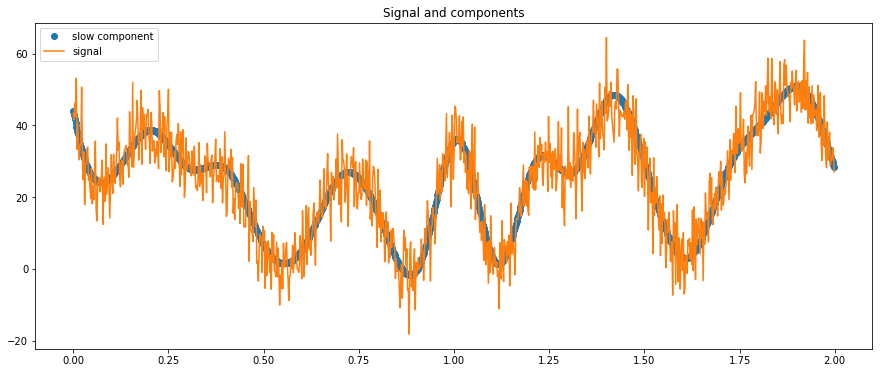

In [20]:
plt.plot(t[0:1000], slow_component[0:1000], 'o', t[0:1000], signal[0:1000], '-')
plt.title("Signal and components")
plt.legend(['slow component', 'signal'], loc='best')
plt.show()

# Filtering with an exponential moving average

In [21]:
# Converting the numpy into a pandas series as it has ewma
pdslow = pd.Series(slow_component, t)
pdsignal = pd.Series(signal, t)
pdsignal_mean = pdsignal.ewm(halflife=8).mean()

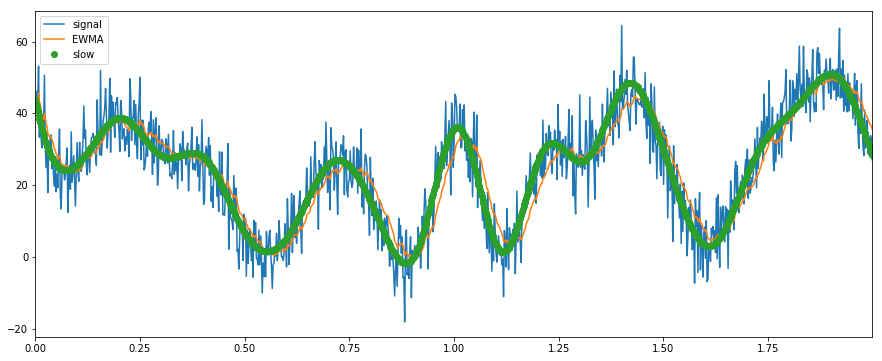

In [22]:
pdsignal.head(1000).plot()
pdsignal_mean.head(1000).plot()
pdslow.head(1000).plot(style='o')
plt.legend(['signal', 'EWMA', 'slow'])
plt.show()

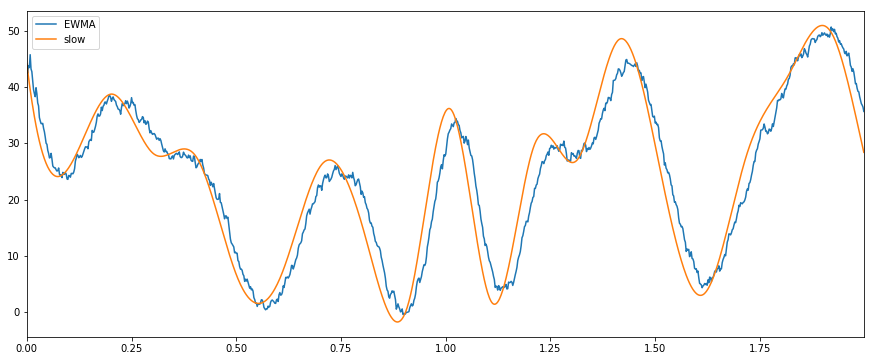

In [23]:

pdsignal_mean.head(1000).plot()
pdslow.head(1000).plot(style='-')
plt.legend(['EWMA', 'slow'])
plt.show()

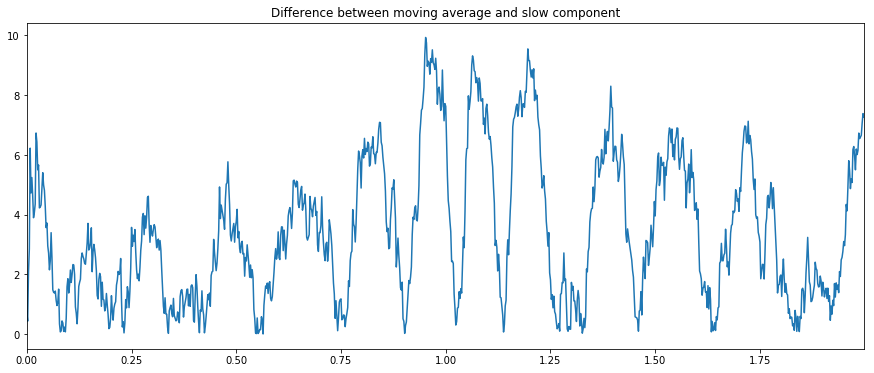

In [24]:
pddiff = abs(pdsignal_mean - pdslow)
pddiff.head(1000).plot()
plt.title("Difference between moving average and slow component")
plt.show()

## Trying a Kalman filter

See https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

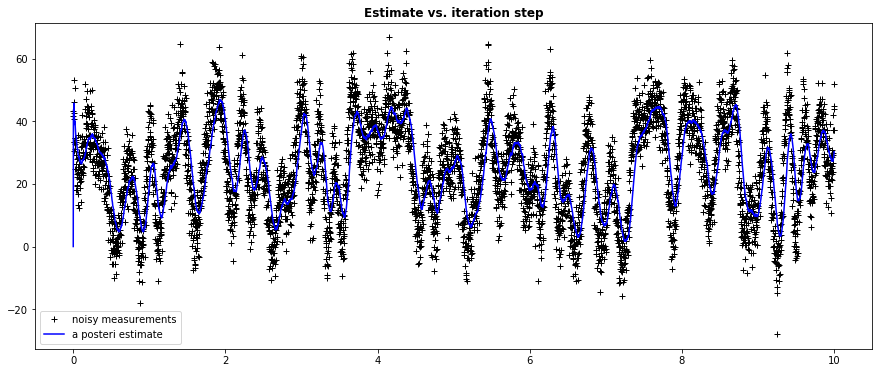

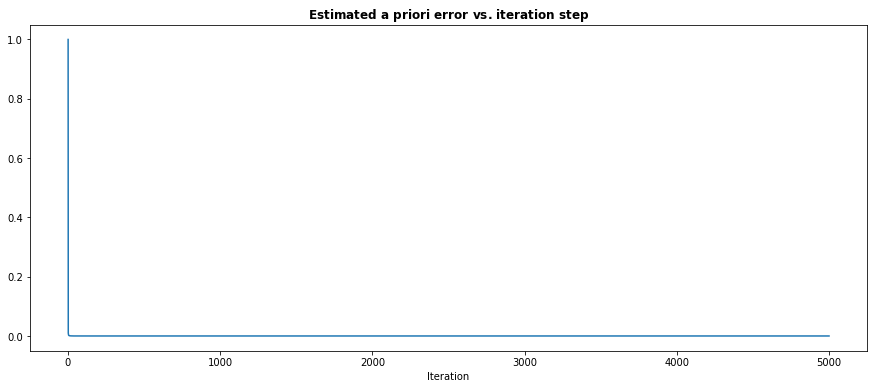

In [25]:
# intial parameters
n_iter = len(signal)
sz = (n_iter,) # size of array
z = signal

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]
    
plt.figure()
plt.plot(t, z,'k+',label='noisy measurements')
plt.plot(t, xhat,'b-',label='a posteri estimate')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.show()
    

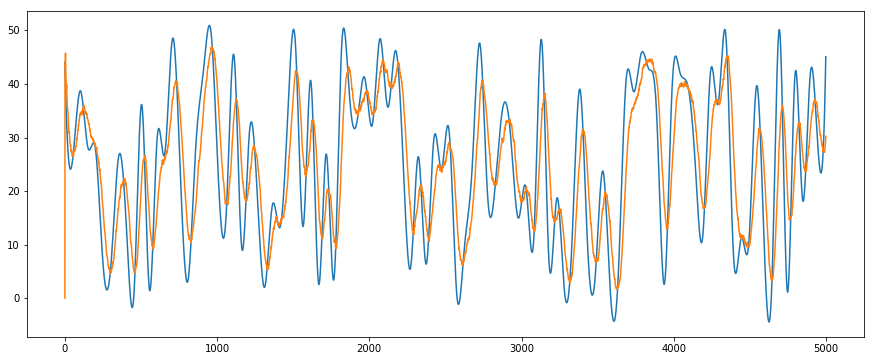

In [26]:
plt.plot(slow_component)
plt.plot(xhat)

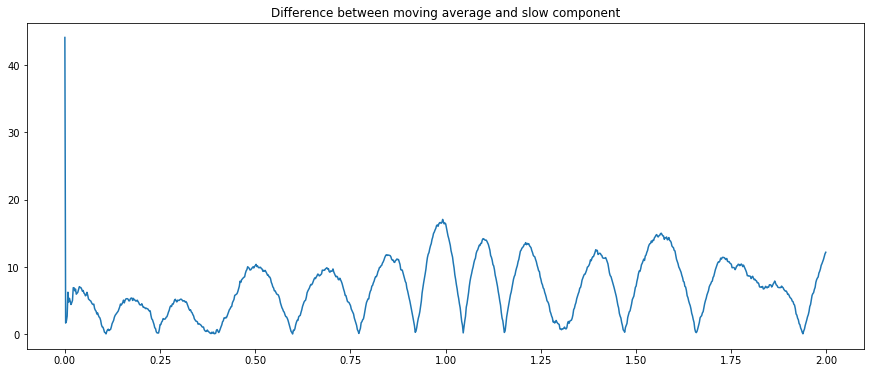

In [27]:
kdiff = abs(xhat - slow_component)
plt.plot(t[0:1000], kdiff[0:1000])
plt.title("Difference between moving average and slow component")
plt.show()